# Monitoring change through time using satellite imagery filmstrip plots <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Background

Understanding how natural and human landscapes have changed through time can provide vital information about the health of local ecosystems and development of the built environment. 
For example, data on changes in the distribution of vegetation in the landscape can be used to monitor the impact of deforestation, or track the recovery of forests after habitat restoration or extreme natural events (e.g. bushfires). 
Tracking changes within urban areas can be used monitor the growth of infrastructure such as ports and transport networks, while data on coastal changes can be vital for predicting and managing the impacts of coastal erosion or the loss of coastal wetlands (e.g. mangroves).

Although these examples of change can be tracked using direct on-the-ground monitoring (e.g. vegetation surveys), it can be extremely challenging and expensive to obtain a comprehensive understanding of these processes at a broader landscape scale. 
For many applications, it can also be extremely useful to obtain a record of the history of a location undergoing change. 
This typically requires historical monitoring data which is unlikely to be available for all but the most intensively monitored locations.

### Digital Earth Australia use case

More than 30 years of satellite imagery from the [NASA/USGS Landsat program](https://www.usgs.gov/land-resources/nli/landsat) is freely available for Australia, making this a powerful resource for monitoring natural and human-driven change across the Australian continent.
Because these satellites image every location over Australia regularly (approximately once every 16 days), they provide an unparalleled archive of how many of Australia's landscapes have changed through time.

Analysing change from individual satellite images can be made difficult by the presence of clouds, cloud shadow, sunglint over water, and dynamic processes like changing tides along the coastline. 
By combining individual noisy images into cleaner, cloud-free "summary" images that cover a longer time period (e.g. one or multiple years), we can obtain a clear, consistent view of the Australian environment that can be compared to reveal changes in the landscape over time.


## Description
In this example, Digital Earth Australia Landsat data is extracted for a given time range and location, and combined using the geometric median ("geomedian") statistic to reveal the median or 'typical' appearance of the landscape for a series of time periods (for more information about geomedians, see the [Geomedian composites notebook](../Frequently_used_code/Geomedian_composites.ipynb)).

For coastal applications, the analysis can be customised to select only satellite images obtained during a specific tidal range (e.g. low, average or high tide). 

The results for each time period are combined into a 'filmstrip' plot which visualises how the landscape has changed in appearance across time, with a 'change heatmap' panel highlighting potential areas of greatest change:

![Example of filmstrip plot](../Supplementary_data/Change_filmstrips/filmstrip_example.JPG)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages used for the analysis.

In [1]:
%matplotlib inline

import sys
from datacube.helpers import write_geotiff

sys.path.append('../Scripts')
from notebookapp_changefilmstrips import run_filmstrip_app


### Analysis parameters

The following cell sets important required parameters for the analysis:

* `output_name`: A name that will be used to name the output filmstrip plot file
* `time_range`: The date range to analyse (e.g. `time_range = ('1988-01-01', '2017-12-31')`)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare (e.g. `time_step = {'years': 5}` will generate one filmstrip plot for every five years of data in the dataset; `time_step = {'months': 18}` will generate one plot for each 18 month period etc.
Time periods are counted from the first value given in `time_range`.

Optional parameters:

* `tide_range`: This parameter allows you to generate filmstrip plots based on specific ocean tide conditions.
This can be valuable for analysing change consistently along the coast. 
For example, `tide_range = (0.0, 0.2)` will select only satellite images acquired at the lowest 20% of tides; `tide_range = (0.8, 1.0)` will select images from the highest 20% of tides. 
The default is `tide_range = (0.0, 1.0)` which will select all images regardless of tide.
* `resolution`: The spatial resolution to load data. 
The default is `resolution = (-30, 30)`, which will load data at 30 m pixel resolution. 
Increasing this (e.g. to `resolution = (-100, 100)`) can be useful for loading large spatial extents.
* `max_cloud`: This parameter allows you to exclude satellite images with excessive cloud. 
The default is `50`, which will keep all images with less than 50% cloud.
* `ls7_slc_off`: Whether to include data from after the Landsat 7 SLC failure (i.e. SLC-off). 
Defaults to `False`, which removes all Landsat 7 observations after May 31 2003.
Setting this to `True` will result in extra data, but can also introduce horizontal striping in the output filmstrip plots.



**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. 


In [2]:
# Required parameters
output_name = 'example'
time_range = ('1988-01-01', '2017-12-31')
time_step = {'years': 5}

# Optional parameters
tide_range = (0.0, 1.0)
resolution = (-30, 30)
max_cloud = 50
ls7_slc_off = False

## Select location and generate filmstrips
Run the following cell to start the analysis. 
This will plot an interactive map that is used to select the area to load satellite data for.

Select the `Draw a rectangle` or `Draw a polygon` tool on the left of the map, and draw a shape around the area you are interested in.

For the first run, try **drawing a square around Sydney Airport and Port Botany** to see an example of change driven by urban and coastal development.

When you are ready, press the green `done` button on the top right of the map. 
This will start loading the data, and then generate a filmstrips plot.

> Depending on the size of the area you select, this step can take **several minutes to complete**.
To keep load times reasonable, select an area **smaller than 20,000 hectares** in size (this limit can be overuled by supplying the `size_limit` parameter in the `run_filmstrip_app` function below).

> Once the analysis reaches the `Generating geomedian composites` step, you can check the status of the data load by clicking the **Dashboard** link under **Client** below.


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Starting analysis...


Client Scheduler: tcp://127.0.0.1:38623 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


Loading ga_ls5t_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Loading ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
    Applying pixel quality/cloud mask
    Applying invalid data mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
Combining and sorting data
    Returning 681 observations as a dask array

Generating geomedian composites and plotting filmstrips... (click the Dashboard link above for status)


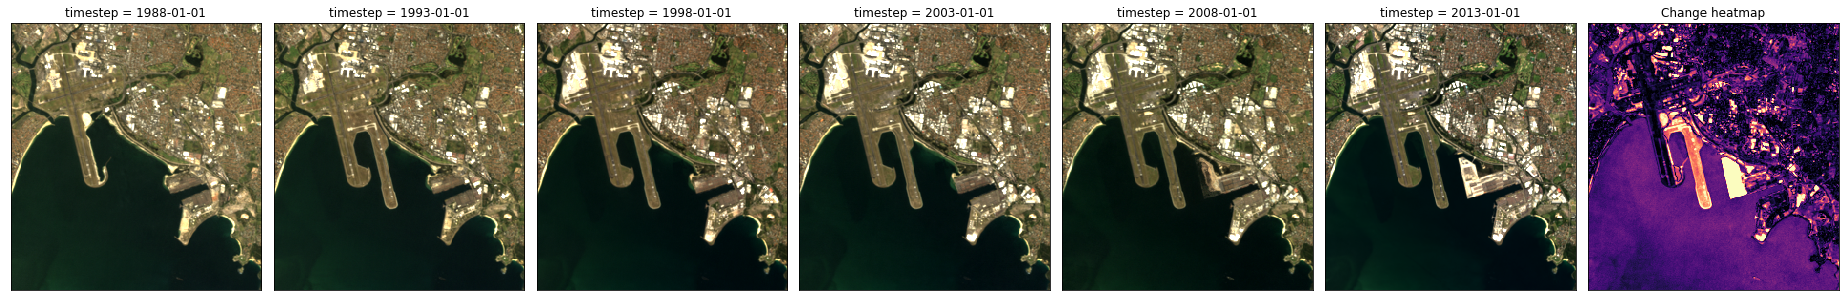

In [3]:
output_data = run_filmstrip_app(output_name,
                                time_range,
                                time_step,
                                tide_range,
                                resolution,
                                max_cloud,
                                ls7_slc_off)

## Using filmstrip plots to identify change

The filmstrip plot above contains several colour imagery panels that summarise the median or 'typical' appearance of the landscape for the time periods defined using `time_range` and `time_step`. 
If you ran the analysis over the Sydney Airport and Port Botany area, inspect each of the imagery plots. 
Some key examples of change that appear include: 

* The 1994 construction of Sydney Airport's third runway in the second panel (covering the five year period between 1993 and 1998)
* The 2011 expansion of Port Botany visible as construction in the fifth panel, and completed by the sixth panel
* Increasing commercial and industrial development (e.g. large white roofs) in the suburb of Mascot north of Port Botany

### Change heatmap

To make it easier to identify areas that have changed between each filmstrip panel, the final panel provides a "change heatmap".
This highlights pixels whose values vary greatly between the panels in the filmstrip plot. 
Bright colours indicate pixels that have changed; dark colours indicate pixels that have remained relatively similar across time.

Compare the "change heatmap" panel against the colour imagery panels. 
You should be able to clearly see Sydney Airport's third runway and the Port Botany port expansion highlighted in bright colours.

> **Technical info:** The "change heatmap" is calculated by first taking a log transform of the imagery data to emphasize dark pixels, then calculating standard deviation across all of the filmstrip panels to reveal pixels that changed over time.

## Downloading filmstrip plot
The high resolution version of the filmstrip plot generated above will be saved to the same location you are running this notebook from (e.g. typically `Real_world_examples`). 
In JupyterLab, use the file browser to locate the image file with a name in the following format: 

`filmstrip_{output_name}_{date_string}_{time_step}.png`

If you are using the **DEA Sandbox**, you can download the image to your PC by right clicking on the image file and selecting `Download`.

## Export GeoTIFF data
It can be useful to export each of the filmstrip panels generated above as GeoTIFF raster files so that they can be loaded into a Geographic Information System (GIS) software for further analysis.
Because the filmstrip panels were generated using the "geomedian" statistic that preserves relationships between spectral bands, the resulting data can be validly analysed in the same way as we would analyse an individual satellite image.

To export the GeoTIFFs, run the following cell then right click on the files in the JupyterLab file browser and select `Download`.

In [4]:
for i, ds in output_data.groupby('timestep'):
    print(f'Exporting {i} data')
    write_geotiff(dataset=ds, filename=f'geotiff_{output_name}_{i}.tif')

Exporting 1988-01-01 data
Exporting 1993-01-01 data
Exporting 1998-01-01 data
Exporting 2003-01-01 data
Exporting 2008-01-01 data
Exporting 2013-01-01 data


## Next steps
When you are done, return to the [Analysis parameters](#Analysis-parameters) section, modify some values and rerun the analysis. 
For example, you could try:

* Modify `time_range` to look at a specific time period of interest (e.g. `time_range = ('1990-01-01', '2000-01-01')`.
* Setting a shorter `time_step` (e.g. `time_step = {'years': 2}`) for a more detailed look at how the landscape has changed over shorter time periods.
* Inspecting change along the coastline after controlling for tide using the `tide_range` parameter (e.g. `tide_range = (0.0, 0.3)` to look at the landscape during the lowest 30% of tides). 
For the best results, test this out in an area with high tides such as [Roebuck Bay in West Australia's Kimberley region](https://goo.gl/maps/ZkCcXUSbsVhRMsgM9).


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [5]:
import datacube
print(datacube.__version__)

1.7+255.gdb5854af.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)